### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
tensorflow.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD

/home/shayan/.local/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
train_dir = r'/home/shayan/PycharmProjects/emotion-detection/train'
test_dir = r'/home/shayan/PycharmProjects/emotion-detection/test'

### Train, Validation and Test sets

In [3]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   validation_split=0.2,

                                   rotation_range=5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1. / 255,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [4]:
train_data  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

valid_data = valid_datagen.flow_from_directory(directory = train_dir,
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

test_data = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 22967 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [13]:
#check shape of batch
x_batch, y_batch = train_data.next()
print('x_batch.shape={0} y_batch.shape={1}'.format(x_batch.shape, y_batch.shape))

x_batch.shape=(64, 48, 48, 3) y_batch.shape=(64, 7)


### Transfer learning using pre-trained ResNet50 model without the top layer

In [ ]:
base_model = ResNet50(input_shape=(48, 48, 3), weights='imagenet', include_top=False)

### Build the top layer of ResNet architecture: add dense layer, followed by a dense layer with softmax activation

In [7]:
model = Sequential()
model.add(base_model) #the pre-trained ResNet model
model.add(Flatten()) #flattens the output of the pre-trained model into a 1D vector
model.add(Dense(256, activation='relu')) #a fully connected layer with 256 units using ReLU as activation function
model.add(Dropout(0.5)) #dropout layer to avoid overfitting
model.add(Dense(7, activation='softmax')) #the final fully connected layer with 7 units using softmax as activation function

base_model.trainable = False #freeze the weights of the base model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 6s 0us/step


### Train the ResNet model

In [8]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
359/359 [==============================] - 100s 271ms/step - loss: 1.8641 - accuracy: 0.2355 - val_loss: 1.8077 - val_accuracy: 0.2513
Epoch 2/10
359/359 [==============================] - 100s 277ms/step - loss: 1.8252 - accuracy: 0.2510 - val_loss: 1.8095 - val_accuracy: 0.2513
Epoch 3/10
359/359 [==============================] - 94s 262ms/step - loss: 1.8216 - accuracy: 0.2510 - val_loss: 1.8143 - val_accuracy: 0.2513
Epoch 4/10
359/359 [==============================] - 97s 269ms/step - loss: 1.8228 - accuracy: 0.2511 - val_loss: 1.8079 - val_accuracy: 0.2513
Epoch 5/10
359/359 [==============================] - 96s 268ms/step - loss: 1.8191 - accuracy: 0.2513 - val_loss: 1.8080 - val_accuracy: 0.2513
Epoch 6/10
359/359 [==============================] - 99s 275ms/step - loss: 1.8180 - accuracy: 0.2513 - val_loss: 1.8135 - val_accuracy: 0.2513
Epoch 7/10
359/359 [==============================] - 113s 314ms/step - loss: 1.8161 - accuracy: 0.2513 - val_loss: 1.8144 - val

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 25,686,919
Trainable params: 2,099,207
Non-trainable params: 23,587,712
_________________________________________________________________


### Plot train, validation accuracy and tran, validation loss

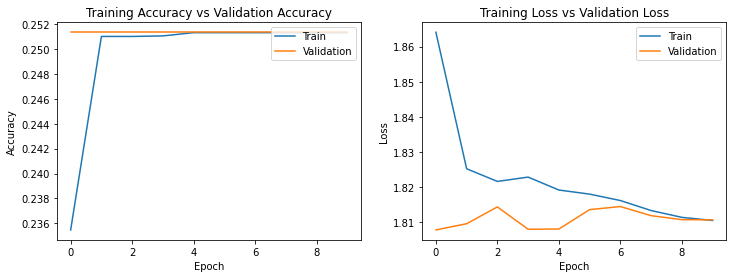

In [11]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

### build another ResNet model and unfreeze the last 2 layers

In [15]:
base_model = ResNet50(include_top=False, input_shape=(48, 48, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)
for layer in base_model.layers[:-2]:
    layer.trainable = False

### Fine tune the newly built ResNet model

In [17]:
fine1_model = Model(inputs=base_model.input, outputs=predictions)
opt = SGD(learning_rate=0.0001, momentum=0.9) #hyper-parameters tuning
fine1_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### Train the fine tuned model

In [19]:
history = fine1_model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
359/359 [==============================] - 91s 247ms/step - loss: 1.8290 - accuracy: 0.2425 - val_loss: 1.8076 - val_accuracy: 0.2533
Epoch 2/10
359/359 [==============================] - 92s 258ms/step - loss: 1.8147 - accuracy: 0.2433 - val_loss: 1.7977 - val_accuracy: 0.2505
Epoch 3/10
359/359 [==============================] - 113s 314ms/step - loss: 1.8092 - accuracy: 0.2450 - val_loss: 1.7963 - val_accuracy: 0.2522
Epoch 4/10
359/359 [==============================] - 114s 318ms/step - loss: 1.8093 - accuracy: 0.2488 - val_loss: 1.8048 - val_accuracy: 0.2580
Epoch 5/10
359/359 [==============================] - 110s 306ms/step - loss: 1.8056 - accuracy: 0.2489 - val_loss: 1.7978 - val_accuracy: 0.2531
Epoch 6/10
359/359 [==============================] - 116s 323ms/step - loss: 1.8019 - accuracy: 0.2538 - val_loss: 1.7924 - val_accuracy: 0.2533
Epoch 7/10
359/359 [==============================] - 115s 321ms/step - loss: 1.8025 - accuracy: 0.2467 - val_loss: 1.7974 - v

In [20]:
fine1_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

### Plot train, validation accuracy and tran, validation loss

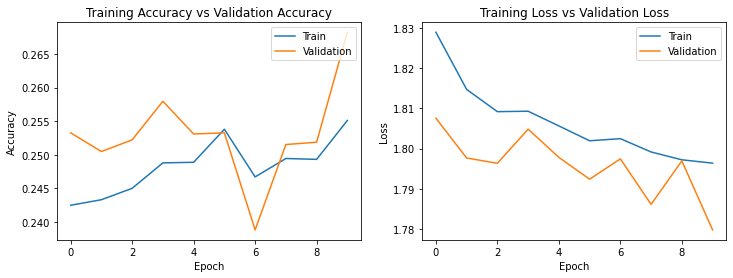

In [21]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

### build another ResNet model and unfreeze the last 20 layers

In [22]:
base_model = ResNet50(include_top=False, input_shape=(48, 48, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)
for layer in base_model.layers[-20:]:
    layer.trainable = True

2023-03-24 13:56:50.014412: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 209715200 exceeds 10% of free system memory.


### Fine tune the newly built model

In [22]:
fine2_model = Model(inputs=base_model.input, outputs=predictions)
opt = SGD(learning_rate=0.00005, momentum=0.6) #hyper-parameters tuning
fine2_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### Train the fine tuned model

In [23]:
history = fine2_model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
359/359 [==============================] - 128s 345ms/step - loss: 1.7896 - accuracy: 0.2563 - val_loss: 1.7765 - val_accuracy: 0.2527
Epoch 2/10
359/359 [==============================] - 117s 326ms/step - loss: 1.7860 - accuracy: 0.2570 - val_loss: 1.7784 - val_accuracy: 0.2540
Epoch 3/10
359/359 [==============================] - 116s 322ms/step - loss: 1.7872 - accuracy: 0.2583 - val_loss: 1.7785 - val_accuracy: 0.2534
Epoch 4/10
359/359 [==============================] - 116s 323ms/step - loss: 1.7867 - accuracy: 0.2577 - val_loss: 1.7752 - val_accuracy: 0.2541
Epoch 5/10
359/359 [==============================] - 115s 321ms/step - loss: 1.7869 - accuracy: 0.2564 - val_loss: 1.7725 - val_accuracy: 0.2588
Epoch 6/10
359/359 [==============================] - 115s 321ms/step - loss: 1.7860 - accuracy: 0.2599 - val_loss: 1.7754 - val_accuracy: 0.2557
Epoch 7/10
359/359 [==============================] - 118s 329ms/step - loss: 1.7875 - accuracy: 0.2580 - val_loss: 1.7746 -

In [24]:
fine2_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

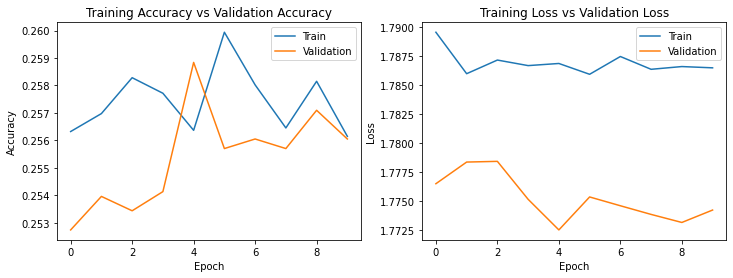

In [25]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper right')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

### Conclusion: After building and training 3 different ResNet model, the fine tuned model with the unfreezed last two layers is the best one. The accuracy is not ve